[# Computational Photonics]:#

[## Homework 1: Implementation of a Finite-Difference Mode Solver]:#

[Author:]:#
[| Name             | Email       |
| -----------      | ----------- |
| *Udit Banerjee*    |             |
| *John Fearnhead*   |             |
|                  |             |
| *Yucheng Sun*      |             |
]:#
[Supervisor:]:#
[>Prof. Thomas Pertsch]:#


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sps
from scipy.sparse.linalg import eigs

**Table of contents**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
- 2. [Analysis and Simulation of the Problems](#toc2_)    
  - 2.1. [Guided modes in 1+1=2D systems (TE modes)](#toc2_1_)    
    - 2.1.1. [Discussion of physical properties of numerical solutions](#toc2_1_1_)    
    - 2.1.2. [Discussion of numerical properties of numerical solutions](#toc2_1_2_)    
  - 2.2. [Guided modes in 2+1=3D systems (strip waveguide) in scalar approximation](#toc2_2_)    
    - 2.2.1. [Discussion of physical properties of numerical solutions](#toc2_2_1_)    
    - 2.2.2. [Discussion of numerical properties of numerical solutions](#toc2_2_2_)    
- 3. [Conclusions](#toc3_)    
- 4. [References](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introduction](#toc0_)

## 2. <a id='toc2_'></a>[Analysis and Simulation of the Problems](#toc0_)


### 2.1. <a id='toc2_1_'></a>[Guided modes in 1+1=2D systems (TE modes)](#toc0_)


In [2]:
def guided_modes_1DTE(prm, k0, h):
    """Computes the effective permittivity of a TE polarized guided eigenmode.
    All dimensions are in µm.
    Note that modes are filtered to match the requirement that
    their effective permittivity is larger than the substrate (cladding).
    
    Parameters
    ----------
    prm : 1d-array
        Dielectric permittivity in the x-direction
    k0 : float
        Free space wavenumber
    h : float
        Spatial discretization
    
    Returns
    -------
    eff_eps : 1d-array
        Effective permittivity vector of calculated modes
    guided : 2d-array
        Field distributions of the guided eigenmodes
    """
    dt = np.common_type(np.array([prm]))
    # Construct the matrix M and B for the gernerlized eigenvalue problem
    M  = np.zeros((len(prm),len(prm)), dtype = dt)
    for i in range(len(prm)):
        M[i][i] =  -2/(h**2) + (k0**2) * prm[i]
        if i > 0:
            M[i][i-1] = 1/(h**2) 
        if i < len(prm) - 1:
            M[i][i+1] = 1/(h**2)
    M  = (1/(k0**2)) * M
    eff_eps, guided = np.linalg.eig(M)
    return eff_eps, guided


- Define and generate the parameters

In [3]:
grid_size     = 120
number_points = 601
h             = grid_size/(number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0
xx            = np.linspace( -grid_size/2, grid_size/2, number_points )
prm           = e_substrate + delta_e * np.exp(-(xx/w)**2)

# Compute the eigenvalues and eigenvectors
eff_eps, guided = guided_modes_1DTE(prm, k0, h)

- Selection of modes (effective permittivity and field distribution)

selected_eff_eps:  2.2602766289446756
selected_guided:  [-2.92260134e-15 -5.62601621e-15 -6.13610439e-15 -5.32506176e-15
 -6.42759456e-15 -7.90129827e-15 -8.57545315e-15 -8.78045278e-15
 -6.92754233e-15 -3.83650977e-15  1.68509664e-15  9.08087586e-15
  1.44497363e-14  1.93012057e-14  2.29375814e-14  2.34804749e-14
  2.08280126e-14  1.67284969e-14  1.26075355e-14  8.02717445e-15
  5.16364427e-15  2.38227935e-15 -1.69984512e-15 -4.16218269e-15
 -4.87448927e-15 -3.94229039e-15 -1.81246632e-15  1.47862081e-15
  5.74107638e-15  9.58249997e-15  1.27348107e-14  1.34851950e-14
  1.15494060e-14  5.96424866e-15  6.80502545e-16 -3.87995062e-15
 -6.11317489e-15 -7.54138834e-15 -1.00089101e-14 -9.18726554e-15
 -9.28916049e-15 -8.73393773e-15 -9.85969170e-15 -1.38991450e-14
 -1.63850713e-14 -1.75766706e-14 -1.92910668e-14 -1.80573813e-14
 -1.44728670e-14 -7.77838590e-15  5.46033397e-18  5.93448466e-15
  1.19099209e-14  1.99098818e-14  2.67954423e-14  2.97602294e-14
  3.21031965e-14  3.69512977e-14  

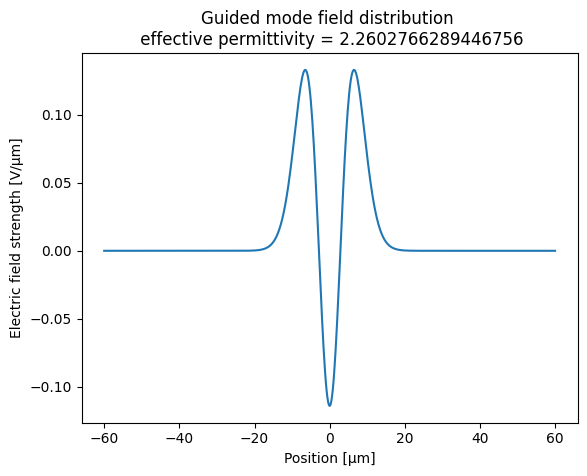

In [7]:
# Filter the eigenvalues and eigenvectors
## Find the indices of the eigenvalues within the given range
indices = np.where((eff_eps >= e_substrate) & (eff_eps <= e_substrate + delta_e))[0]

## Extract the eigenvalues and eigenvectors within the range
selected_eff_eps = eff_eps[indices]
selected_guided = (np.transpose(guided))[indices]
mode_ind = int(2)
print('selected_eff_eps: ', selected_eff_eps[mode_ind])
print('selected_guided: ', selected_guided[mode_ind])

# Plot the eigenvalues and eigenvectors
x = xx
y = selected_guided[mode_ind]
plt.plot(x, y)
plt.xlabel('Position [µm]')
plt.ylabel('Electric field strength [V/µm]')
plt.title('Guided mode field distribution \n effective permittivity = ' + str(selected_eff_eps[mode_ind]))
plt.show()

#### 2.1.1. <a id='toc2_1_1_'></a>[Discussion of physical properties of numerical solutions](#toc0_)

#### 2.1.2. <a id='toc2_1_2_'></a>[Discussion of numerical properties of numerical solutions](#toc0_)

### 2.2. <a id='toc2_2_'></a>[Guided modes in 2+1=3D systems (strip waveguide) in scalar approximation](#toc0_)

In [4]:
def guided_modes_2D(prm, k0, h, numb):
    """Computes the effective permittivity of a quasi-TE polarized guided 
    eigenmode. All dimensions are in µm.
    
    Parameters
    ----------
    prm  : 2d-array
        Dielectric permittivity in the xy-plane
    k0 : float
        Free space wavenumber
    h : float
        Spatial discretization
    numb : int
        Number of eigenmodes to be calculated
    
    Returns
    -------
    eff_eps : 1d-array
        Effective permittivity vector of calculated eigenmodes
    guided : 2d-array
        Field distributions of the guided eigenmodes
    """
    dt = np.common_type(np.array([prm]))
    # M  = np.zeros((np.size(prm), np.size(prm)), dtype = dt)
    # for i  in range(np.size(prm)):
    #     M[i][i] =  -4/(h**2) + (k0**2) * prm.flatten()[i]
    #     if i > 0 & i % np.size(prm,1) != 0:
    #         M[i][i-1] = 1/(h**2)
    #     if i < len(prm) - 1 & i % np.size(prm,1) != np.size(prm,1) - 1:
    #         M[i][i+1] = 1/(h**2)
    #     if i >= np.size(prm,1):
    #         M[i][i-np.size(prm,1)] = 1/(h**2)
    #     if i < len(prm) - np.size(prm,1):
    #         M[i][i+np.size(prm,1)] = 1/(h**2)
    # M  = (1/(k0**2)) * M
    # Set the diagonal elements
    diagonals = np.zeros((5, np.size(prm)))
    diagonals[0] = -4/(h**2) + (k0**2) * prm.flatten()
    for i in range(np.size(prm) - 1):
        if i % len(prm[0]) != len(prm[0]) - 1:
            diagonals[1][i] = 1/(h**2)
        if i % len(prm[0]) != 0:
            diagonals[2][i] = 1/(h**2)
        if i < np.size(prm) - len(prm[0]):
            diagonals[3][i] = 1/(h**2)
        if i >= len(prm[0]):
            diagonals[4][i] = 1/(h**2)
    diag_position = [0, 1, -1, len(prm[0]), -len(prm[0])]
    # Create a sparse 2D array with the diagonal elements
    M = sps.diags(diagonals, diag_position)
    M = (1/(k0**2)) * M
    # Compute the eigenvalues and eigenvectors
    eff_eps, guided = sps.linalg.eigs(M, k = numb, which = 'LR')
    min_val = prm.min()
    max_val = prm.max()
    # while abs(eff_eps[0]) < min_val or abs(eff_eps[0]) > max_val:
    #     eff_eps, guided = eigs(M, k=1, which='LR')
    return eff_eps, guided

- Define and generate the parameters

In [5]:
# Define the parameters
grid_size     = 120
number_points = 301
h             = grid_size/(number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0
xx            = np.linspace(-grid_size/2,grid_size/2,number_points)
yy            = np.linspace(-grid_size/2,grid_size/2,number_points)
XX,YY         = np.meshgrid(xx,yy)
prm           = e_substrate + delta_e * np.exp(-(XX**2+YY**2)/w**2)
numb          = 2

- Selection of modes (effective permittivity and field distribution)

In [ ]:
mod_ind = 0
print(eff_eps)
print(guided)

# Plot the eigenmode
X, Y = XX, YY
Z = np.real(np.transpose(guided)[mod_ind].reshape((number_points, number_points)))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
## Customize the z axis.
ax.set_zlim(np.min(Z), np.max(Z))
ax.zaxis.set_major_locator(LinearLocator(10))
## Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

#### 2.2.1. <a id='toc2_2_1_'></a>[Discussion of physical properties of numerical solutions](#toc0_)

#### 2.2.2. <a id='toc2_2_2_'></a>[Discussion of numerical properties of numerical solutions](#toc0_)

## 3. <a id='toc3_'></a>[Conclusions](#toc0_)

## 4. <a id='toc4_'></a>[References](#toc0_)